In [2]:
# Data I/O and preprocessing
import numpy as np
import pandas as pd
import pyarrow.parquet as pq

# System
import time
import os
import gc

# Graphic
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from tqdm import tqdm

# multiprocessing
import multiprocessing

In [37]:
# Data setting
train_batch_id_first = 1
train_batch_id_last = 330

train_batch_ids = range(train_batch_id_first, train_batch_id_last + 1)

max_pulse_count = 96
bin_num = 8
n_features = 11  # time, charge, aux, x, y, z, absorbtion, scattering, r_err, z_err, rank

In [38]:
# directory
home_dir = "./dataset/icecube-neutrinos-in-deep-ice/"
train_format = home_dir + 'train/batch_{batch_id:d}.parquet'
test_format = home_dir + 'test/batch_{batch_id:d}.parquet'

point_picker_format = './tf_dataset/aux_pointpicker_mp96_n11_batch_{batch_id:d}.npz'

# Set Detector Geometry

In [5]:
%%time

# sensor_geometry
sensor_geometry_df = pd.read_csv(home_dir + "sensor_geometry.csv")

# counts
doms_per_string = 60
string_num = 86

# index
outer_long_strings = np.concatenate([np.arange(0, 25), np.arange(27, 34), np.arange(37, 44), np.arange(46, 78)])
inner_long_strings = np.array([25, 26, 34, 35, 36, 44, 45])
inner_short_strings = np.array([78, 79, 80, 81, 82, 83, 84, 85])

# known specs
outer_xy_resolution = 125. / 2
inner_xy_resolution = 70. / 2
long_z_resolution = 17. / 2
short_z_resolution = 7. / 2

# evaluate error
sensor_x = sensor_geometry_df.x
sensor_y = sensor_geometry_df.y
sensor_z = sensor_geometry_df.z
sensor_r_err = np.ones(doms_per_string * string_num)
sensor_z_err = np.ones(doms_per_string * string_num)

for string_id in outer_long_strings:
    sensor_r_err[string_id * doms_per_string:(string_id + 1) * doms_per_string] *= outer_xy_resolution
for string_id in np.concatenate([inner_long_strings, inner_short_strings]):
    sensor_r_err[string_id * doms_per_string:(string_id + 1) * doms_per_string] *= inner_xy_resolution

for string_id in outer_long_strings:
    sensor_z_err[string_id * doms_per_string:(string_id + 1) * doms_per_string] *= long_z_resolution
for string_id in np.concatenate([inner_long_strings, inner_short_strings]):
    for dom_id in range(doms_per_string):
        z = sensor_z[string_id * doms_per_string + dom_id]
        if (z < -156.) or (z > 95.5 and z < 191.5):
            sensor_z_err[string_id * doms_per_string + dom_id] *= short_z_resolution
# register
sensor_geometry_df["r_err"] = sensor_r_err
sensor_geometry_df["z_err"] = sensor_z_err

CPU times: user 11.6 ms, sys: 0 ns, total: 11.6 ms
Wall time: 19.8 ms


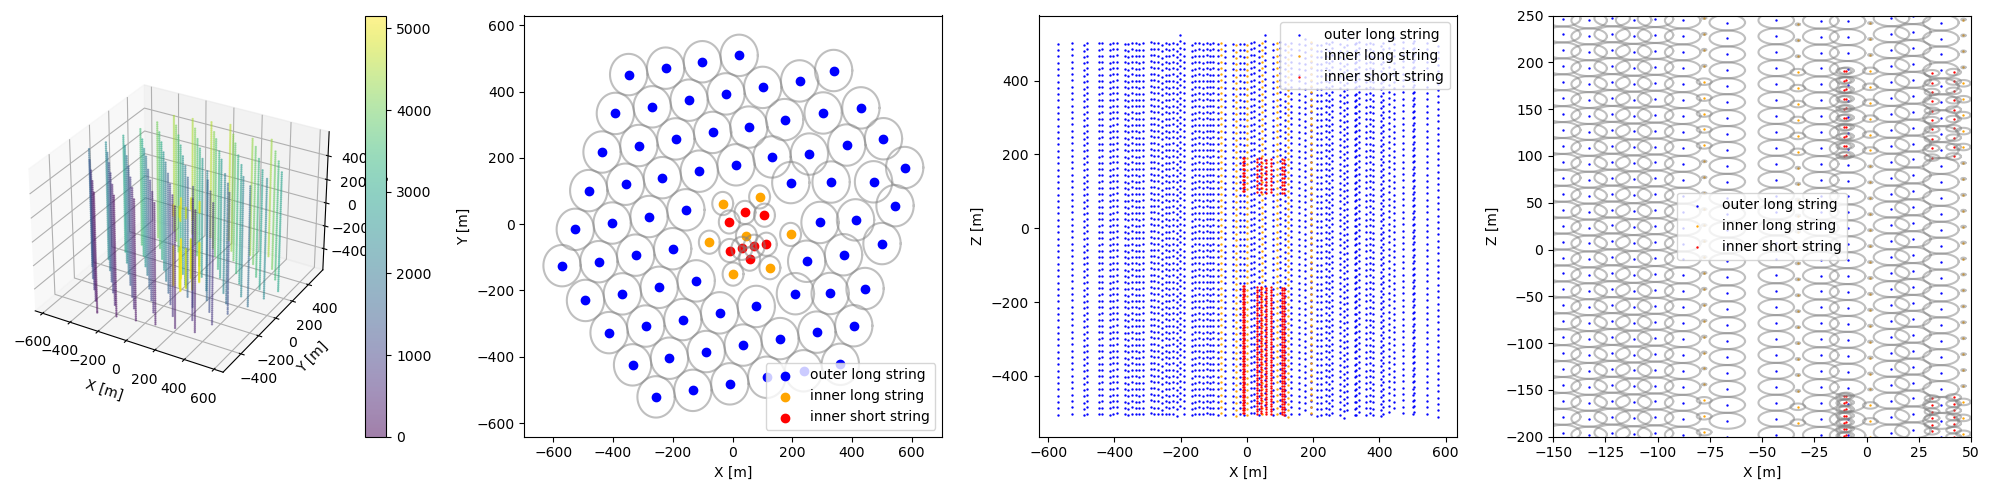

In [6]:
theta = np.linspace(0, 2 * np.pi, 361)

fig = plt.figure(figsize=(20, 5))

# 3D plot
ax = fig.add_subplot(141, projection='3d')

s = ax.scatter(sensor_x, sensor_y, sensor_z, s=0.5, c=np.arange(len(sensor_x)), alpha=0.5)

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")

fig.colorbar(s, ax=ax)

# X-Y plot
ax = fig.add_subplot(142)

for string_id in outer_long_strings:
    x = sensor_x[string_id * doms_per_string]
    y = sensor_y[string_id * doms_per_string]
    r_err = sensor_r_err[string_id * doms_per_string]
    scatter_outer_long = ax.scatter(x, y, color="blue", label="outer long string")
    ax.plot(x + r_err * np.cos(theta), y + r_err * np.sin(theta), color="gray", alpha=0.5)
    
for string_id in inner_long_strings:
    x = sensor_x[string_id * doms_per_string]
    y = sensor_y[string_id * doms_per_string]
    r_err = sensor_r_err[string_id * doms_per_string]
    scatter_inner_long = ax.scatter(x, y, color="orange", label="inner long string")
    ax.plot(x + r_err * np.cos(theta), y + r_err * np.sin(theta), color="gray", alpha=0.5)
    
for string_id in inner_short_strings:
    x = sensor_x[string_id * doms_per_string]
    y = sensor_y[string_id * doms_per_string]
    r_err = sensor_r_err[string_id * doms_per_string]
    scatter_inner_short = ax.scatter(x, y, color="red", label="inner short string")
    ax.plot(x + r_err * np.cos(theta), y + r_err * np.sin(theta), color="gray", alpha=0.5)

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.legend(handles=[scatter_outer_long, scatter_inner_long, scatter_inner_short])

# X-Z plot
ax = fig.add_subplot(143)

for string_id in outer_long_strings:
    x = sensor_x[string_id * doms_per_string:string_id * doms_per_string + doms_per_string]
    z = sensor_z[string_id * doms_per_string:string_id * doms_per_string + doms_per_string]
    scatter_outer_long = ax.scatter(x, z, s=0.5, color="blue", label="outer long string")
    
for string_id in inner_long_strings:
    x = sensor_x[string_id * doms_per_string:string_id * doms_per_string + doms_per_string]
    z = sensor_z[string_id * doms_per_string:string_id * doms_per_string + doms_per_string]
    scatter_inner_long = ax.scatter(x, z, s=0.5, color="orange", label="inner long string")

for string_id in inner_short_strings:
    x = sensor_x[string_id * doms_per_string:string_id * doms_per_string + doms_per_string]
    z = sensor_z[string_id * doms_per_string:string_id * doms_per_string + doms_per_string]
    scatter_inner_short = ax.scatter(x, z, s=0.5, color="red", label="inner short string")

ax.set_xlabel("X [m]")
ax.set_ylabel("Z [m]")
ax.legend(handles=[scatter_outer_long, scatter_inner_long, scatter_inner_short])

# X-Z plot zoom
ax = fig.add_subplot(144)

for string_id in outer_long_strings:
    x = sensor_x[string_id * doms_per_string:string_id * doms_per_string + doms_per_string]
    z = sensor_z[string_id * doms_per_string:string_id * doms_per_string + doms_per_string]
    scatter_outer_long = ax.scatter(x, z, s=0.5, color="blue", label="outer long string")
    
for string_id in inner_long_strings:
    x = sensor_x[string_id * doms_per_string:string_id * doms_per_string + doms_per_string]
    z = sensor_z[string_id * doms_per_string:string_id * doms_per_string + doms_per_string]
    scatter_inner_long = ax.scatter(x, z, s=0.5, color="orange", label="inner long string")

for string_id in inner_short_strings:
    x = sensor_x[string_id * doms_per_string:string_id * doms_per_string + doms_per_string]
    z = sensor_z[string_id * doms_per_string:string_id * doms_per_string + doms_per_string]
    scatter_inner_short = ax.scatter(x, z, s=0.5, color="red", label="inner short string")

for sensor_id in range(doms_per_string * string_num):
    x = sensor_x[sensor_id]
    z = sensor_z[sensor_id]
    z_err = sensor_z_err[sensor_id]
    if (x > -150 and x < 50) and (z > -200 and z < 250):
        ax.plot(x + z_err * np.cos(theta), z + z_err * np.sin(theta), color="gray", alpha=0.5)

ax.set_xlabel("X [m]")
ax.set_ylabel("Z [m]")
ax.set_xlim(-150, 50)
ax.set_ylim(-200, 250)
ax.legend(handles=[scatter_outer_long, scatter_inner_long, scatter_inner_short])

fig.tight_layout()
plt.show()

In [7]:
# detector constants
c_const = 0.299792458  # speed of light [m/ns]

x_min = sensor_x.min()
x_max = sensor_x.max()
y_min = sensor_y.min()
y_max = sensor_y.max()
z_min = sensor_z.min()
z_max = sensor_z.max()

detector_length = np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2 + (z_max - z_min)**2)
t_valid_length = detector_length / c_const

print("t_valid_length: ", t_valid_length, " ns")

t_valid_length:  6199.700247193777  ns


# Data I/O Helper

## Single event reader function

- Pick-up important data points first
    - Rank 3 (First)
        - not aux, in valid time window
    - Rank 2
        - not aux, out of valid time window
    - Rank 1
        - aux, in valid time window
    - Rank 0 (Last)
        - aux, out of valid time window
    - In each ranks, take pulses from highest charge

In [8]:
from sklearn.preprocessing import RobustScaler
from scipy.interpolate import interp1d

def ice_transparency(data_path, datum=1950):
    # Data from page 31 of https://arxiv.org/pdf/1301.5361.pdf
    # Datum is from footnote 8 of page 29
    df = pd.read_csv(data_path, delim_whitespace=True)
    df["z"] = df["depth"] - datum
    df["z_norm"] = df["z"] / 500
    df[["scattering_len_norm", "absorption_len_norm"]] = RobustScaler().fit_transform(
        df[["scattering_len", "absorption_len"]]
    )

    # These are both roughly equivalent after scaling
    f_scattering = interp1d(df["z_norm"], df["scattering_len_norm"])
    f_absorption = interp1d(df["z_norm"], df["absorption_len_norm"])
    return f_scattering, f_absorption
f_scattering, f_absorption = ice_transparency('./ice_transparency/ice_transparency.csv')

In [39]:
# read single event from batch_meta_df
def read_event(event_idx, batch_meta_df, max_pulse_count, batch_df, train=True):
    # read metadata
    batch_id, first_pulse_index, last_pulse_index = batch_meta_df.iloc[event_idx][["batch_id", "first_pulse_index", "last_pulse_index"]].astype("int")

    # read event
    event_feature = batch_df[first_pulse_index:last_pulse_index + 1]
    sensor_id = event_feature.sensor_id
    
    # merge features into single structured array
    dtype = [
        ("time", "float16"),
        ("charge", "float16"),
        ("auxiliary", "float16"),
        ("x", "float16"),
        ("y", "float16"),
        ("z", "float16"),
        ("absorbtion", "float16"),
        ("scattering", "float16"),
        ("r_err", "float16"),
        ("z_err", "float16"),
        ("rank", "short"),
    ]
    event_x = np.zeros(last_pulse_index - first_pulse_index + 1, dtype)

    event_x["time"] = event_feature.time.values - event_feature.time.min()
    event_x["charge"] = event_feature.charge.values
    event_x["auxiliary"] = event_feature.auxiliary.values

    event_x["x"] = sensor_geometry_df.x[sensor_id].values
    event_x["y"] = sensor_geometry_df.y[sensor_id].values
    event_x["z"] = sensor_geometry_df.z[sensor_id].values

    
    event_x["absorbtion"] = f_absorption(event_x["z"] / 500)
    event_x["scattering"] = f_scattering(event_x["z"] / 500)

    event_x["r_err"] = sensor_geometry_df.r_err[sensor_id].values
    event_x["z_err"] = sensor_geometry_df.z_err[sensor_id].values
    
    # For long event, pick-up
    if len(event_x) > max_pulse_count:

        aux_idx = np.where(event_x["auxiliary"] == 1.0)[0]
        non_aux_idx = np.where(event_x["auxiliary"] == 0.0)[0]

        if len(non_aux_idx) < max_pulse_count:
            max_length_possible = min(max_pulse_count, len(event_x))
            num_to_sample = max_length_possible - len(non_aux_idx)
            aux_idx = np.random.choice(aux_idx, num_to_sample, replace=False)
            selected_idx = np.concatenate([aux_idx, non_aux_idx])
        else:
            selected_idx = np.random.choice(non_aux_idx, max_pulse_count, replace=False)

        selected_idx = np.sort(selected_idx)
        event_x = event_x[selected_idx]

    if train:
        azimuth, zenith = batch_meta_df.iloc[event_idx][["azimuth", "zenith"]].astype("float16")
        event_y = np.array([azimuth, zenith], dtype="float16")
        
        return event_idx, len(event_x), event_x, event_y
    
    # for test data, just give feature 
    else:
        return event_idx, len(event_x), event_x

# Data I/O (for CPU) & Normalization

- Read data
- Concatenate and convert
- Normalize time, charge and position variables

## Read train metadata and define spliter (for CPU)

In [11]:
%%time
print("for CPU job")

train_meta_df = pd.read_parquet(home_dir + 'train_meta.parquet')

batch_counts = train_meta_df.batch_id.value_counts().sort_index()

batch_max_index = batch_counts.cumsum()
batch_max_index[train_meta_df.batch_id.min() - 1] = 0
batch_max_index = batch_max_index.sort_index()


def train_meta_df_spliter(batch_id):
    return train_meta_df.loc[batch_max_index[batch_id - 1]:batch_max_index[batch_id] - 1]

for CPU job
CPU times: user 8.05 s, sys: 6.64 s, total: 14.7 s
Wall time: 6.38 s


## Read training data

- Takes 400 s / batch
- About 900 MB / batch

In [40]:
%%time


for batch_id in train_batch_ids:
    print("Reading batch ", batch_id, end="")
    # get batch meta data and data
    batch_meta_df = train_meta_df_spliter(batch_id)
    batch_df = pd.read_parquet(train_format.format(batch_id=batch_id))

    # register pulses
    batch_x = np.zeros((len(batch_meta_df), max_pulse_count, n_features), dtype="float16")
    batch_y = np.zeros((len(batch_meta_df), 2), dtype="float16")
    
    batch_x[:, :, 2] = -1
    

    def read_event_local(event_idx):
        return read_event(event_idx, batch_meta_df, max_pulse_count, batch_df, train=True)

    
    # scan events
    iterator = range(len(batch_meta_df))
    # run only one process 

    with multiprocessing.Pool() as pool:
        for event_idx, pulse_count, event_x, event_y in pool.map(read_event_local, iterator):
    # for event_idx, pulse_count, event_x, event_y in map(read_event_local, iterator):
            batch_x[event_idx, :pulse_count, 0] = event_x["time"]
            batch_x[event_idx, :pulse_count, 1] = event_x["charge"]
            batch_x[event_idx, :pulse_count, 2] = event_x["auxiliary"]
            batch_x[event_idx, :pulse_count, 3] = event_x["x"]
            batch_x[event_idx, :pulse_count, 4] = event_x["y"]
            batch_x[event_idx, :pulse_count, 5] = event_x["z"]
            batch_x[event_idx, :pulse_count, 6] = event_x["scattering"]
            batch_x[event_idx, :pulse_count, 7] = event_x["absorbtion"]
            batch_x[event_idx, :pulse_count, 8] = event_x["r_err"]
            batch_x[event_idx, :pulse_count, 9] = event_x["z_err"]
            batch_x[event_idx, :pulse_count, 10] = event_x["rank"]

            batch_y[event_idx] = event_y

    del batch_meta_df, batch_df
    
    # save
    print(" DONE! Saving...")
    np.savez(point_picker_format.format(batch_id=batch_id), x=batch_x, y=batch_y)

Reading batch  1 DONE! Saving...
Reading batch  2 DONE! Saving...
Reading batch  3 DONE! Saving...
Reading batch  4 DONE! Saving...
Reading batch  5 DONE! Saving...
Reading batch  6 DONE! Saving...
Reading batch  7 DONE! Saving...
Reading batch  8 DONE! Saving...
Reading batch  9 DONE! Saving...
Reading batch  10 DONE! Saving...
Reading batch  11 DONE! Saving...
Reading batch  12 DONE! Saving...
Reading batch  13 DONE! Saving...
Reading batch  14 DONE! Saving...
Reading batch  15 DONE! Saving...
Reading batch  16 DONE! Saving...
Reading batch  17 DONE! Saving...
Reading batch  18 DONE! Saving...
Reading batch  19 DONE! Saving...
Reading batch  20 DONE! Saving...
Reading batch  21 DONE! Saving...
Reading batch  22 DONE! Saving...
Reading batch  23 DONE! Saving...
Reading batch  24 DONE! Saving...
Reading batch  25 DONE! Saving...
Reading batch  26 DONE! Saving...
Reading batch  27 DONE! Saving...
Reading batch  28 DONE! Saving...
Reading batch  29 DONE! Saving...
Reading batch  30 DONE!